In [1]:
import sys, os
sys.path.append('./src')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


import pandas as pd 
import numpy as np
import random 
from sklearn.preprocessing import StandardScaler
from umap import UMAP

from model import Encoder, Decoder, OutputLayer
from loss_function import ZINB, maximum_mean_discrepancy, TripletLoss, CircleLoss
from train import train_epoch_mmd

from dataset import dataset
from scipy import sparse

import utils
import model
import train
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from sklearn.preprocessing import LabelEncoder
from metrics import *
import anndata as ad

In [2]:
le = LabelEncoder()

## New version for 8 batches
There seems to be some issue with the original implementation, so I re-write the training and dataset generation code. The clusters are better separated this time. Please check the new code when you have time.

-Ziqi

In [3]:
class dataset(Dataset):

    def __init__(self, counts, anno, time_point, batch_id, group_id):

        assert not len(counts) == 0, "Count is empty"
        # normalize the count
        self.libsizes = np.tile(np.sum(counts, axis = 1, keepdims = True), (1, counts.shape[1]))
        # is the tile necessary?
        
        self.counts_norm = counts/self.libsizes * 100
        self.counts_norm = np.log1p(self.counts_norm)
        self.counts = torch.FloatTensor(counts)

        # further standardize the count
        self.counts_stand = torch.FloatTensor(StandardScaler().fit_transform(self.counts_norm))
        self.anno = torch.Tensor(anno)
        self.libsizes = torch.FloatTensor(self.libsizes)
        self.time_point = torch.Tensor(time_point)
        self.batch_id = torch.Tensor(batch_id)
        self.group_id = torch.Tensor(group_id)

    def __len__(self):
        return self.counts.shape[0]
    
    def __getitem__(self, idx):
        # data original data, index the index of cell, label, corresponding labels, batch, corresponding batch number
        if self.anno is not None:
            sample = {"batch_id": self.batch_id[idx], "time_point": self.time_point[idx], "group_id": self.group_id[idx], "count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "anno": self.anno[idx], "libsize": self.libsizes[idx]}
        else:
            sample = {"batch_id": self.batch_id[idx], "time_point": self.time_point[idx], "group_id": self.group_id[idx],  "count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "libsize": self.libsizes[idx]}
        return sample


In [4]:
# batch_info = pd.read_csv(r'./data/scp_gex_matrix/processed_sepsis_7533/sepsis_processed_batch_info.csv')
batch_info = pd.read_csv(r'./data/scp_gex_matrix/processed_sepsis_2000/processing_batch/sepsis_processed_batch_info.csv', index_col = 0)

In [5]:
pd.set_option('display.max_rows', None)
batch_info

Control      Leuk-UTI           URO       Int-URO  \
batch_1   (4566, 2000)  (3864, 2000)           NaN           NaN   
batch_2    (705, 2000)   (538, 2000)           NaN           NaN   
batch_3   (5281, 2000)  (1783, 2000)  (2005, 2000)           NaN   
batch_4   (1144, 2000)   (155, 2000)   (260, 2000)           NaN   
batch_5   (5952, 2000)  (4646, 2000)  (2569, 2000)           NaN   
batch_6   (1785, 2000)  (1366, 2000)   (376, 2000)           NaN   
batch_7   (1701, 2000)  (4137, 2000)  (3371, 2000)  (1981, 2000)   
batch_8    (568, 2000)   (343, 2000)    (14, 2000)   (129, 2000)   
batch_11  (4848, 2000)  (4891, 2000)           NaN  (1848, 2000)   
batch_12  (2163, 2000)   (511, 2000)           NaN   (232, 2000)   
batch_13  (3247, 2000)           NaN  (3465, 2000)  (2938, 2000)   
batch_14  (1828, 2000)           NaN   (324, 2000)   (213, 2000)   
batch_15  (6584, 2000)           NaN  (1573, 2000)  (2505, 2000)   
batch_16  (3201, 2000)           NaN   (114, 2000)   (381, 2000)   
batch_17  (3696, 2000)           NaN   (371, 2000)  (3370, 2000)   
batch_18  (1586, 2000)           NaN     (3, 2000)   (278, 2000)   
batch_9            NaN           NaN  (1670, 2000)           NaN   
batch_10           NaN           NaN    (21, 2000)           NaN   
batch_19           NaN           NaN           NaN           NaN   
batch_20           NaN           NaN           NaN           NaN   
batch_21           NaN           NaN           NaN           NaN   
batch_22           NaN           NaN           NaN           NaN   
batch_23           NaN           NaN           NaN           NaN   
batch_24           NaN           NaN           NaN           NaN   
batch_27           NaN           NaN           NaN           NaN   
batch_28           NaN           NaN           NaN           NaN   
batch_26           NaN           NaN           NaN           NaN   
batch_29           NaN           NaN           NaN           NaN   
batch_31           NaN           NaN           NaN           NaN   
batch_32           NaN           NaN           NaN           NaN   
batch_33           NaN           NaN           NaN           NaN   
batch_34           NaN           NaN           NaN           NaN   
batch_35           NaN           NaN           NaN           NaN   

             ICU-NoSEP       ICU-SEP       Bac-SEP  
batch_1            NaN           NaN           NaN  
batch_2            NaN           NaN           NaN  
batch_3            NaN           NaN           NaN  
batch_4            NaN           NaN           NaN  
batch_5            NaN           NaN           NaN  
batch_6            NaN           NaN           NaN  
batch_7            NaN           NaN           NaN  
batch_8            NaN           NaN           NaN  
batch_11           NaN           NaN           NaN  
batch_12           NaN           NaN           NaN  
batch_13           NaN           NaN           NaN  
batch_14           NaN           NaN           NaN  
batch_15           NaN           NaN           NaN  
batch_16           NaN           NaN           NaN  
batch_17           NaN           NaN           NaN  
batch_18           NaN           NaN           NaN  
batch_9            NaN           NaN           NaN  
batch_10           NaN           NaN           NaN  
batch_19  (2323, 2000)  (1948, 2000)           NaN  
batch_20    (78, 2000)    (11, 2000)           NaN  
batch_21  (1406, 2000)   (416, 2000)           NaN  
batch_22    (84, 2000)           NaN           NaN  
batch_23  (1536, 2000)           NaN           NaN  
batch_24   (667, 2000)           NaN           NaN  
batch_27  (1316, 2000)   (500, 2000)           NaN  
batch_28   (609, 2000)    (60, 2000)           NaN  
batch_26           NaN   (308, 2000)           NaN  
batch_29           NaN  (4754, 2000)           NaN  
batch_31           NaN           NaN  (3229, 2000)  
batch_32           NaN           NaN   (578, 2000)  
batch_33           NaN           NaN   (834, 2000)  
batch_

In [6]:
batch_lst = [['Control', 4],
             ['Leuk-UTI', 3],
             ['Int-URO', 7],
             ['URO', 13],
             ['Bac-SEP', 31],
             ['ICU-SEP', 27],
             ['ICU-NoSEP', 19],
             ['Control', 6], 
             ['Leuk-UTI', 5], 
             ['Int-URO', 11], 
             ['URO', 15], 
             ['Bac-SEP', 33], 
             ['ICU-SEP', 29], 
             ['ICU-NoSEP', 21]]

# format: "Cohort Name": ([batch ids], time_point, UTI-label)
# This is strategy 2
batch_dict = {
              'Control': ([12, 14], 0, 0),
              'Leuk-UTI': ([3, 6], 1, 1),
              'Int-URO': ([7, 11], 1, 1),
              'URO': ([9, 15], 1, 1),
              'Bac-SEP': ([33, 35], 2, 0),
              'ICU-SEP': ([19, 27], 2, 0),
             }
# This is strategy 1(the simpler one)
batch_dict_1 = {
              'Leuk-UTI': ([3, 6], 1, 1),
              'Int-URO': ([7, 11], 2, 1),
              'URO': ([9, 15], 3, 1),
             }

In [98]:
# Use all data but ICU-NoSEP, and use "group-id" to label whether this cohort includes UTI symptom,

dir = r'./data/scp_gex_matrix/processed_sepsis_2000/processing_batch'
batchsize = 32
ngenes = 2000
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)

sc_datasets = []
sc_datasets_raw = []
train_loaders = []
test_loaders = []
train_loaders_raw = []
test_loaders_raw = []
n = 0
str_anno = []
for name, labels in batch_dict.items():
    idxes = labels[0]
    time_point = labels[1]
    UTI_label = labels[2]
    time_points = []
    counts_rnas = []
    group_ids = []
    batch_ids = []
    annos = []

    for idx in idxes:
        counts_rna = np.array(sparse.load_npz(os.path.join(dir, '{}/mtx_{}_batch_{}.npz'.format(name,name,idx))).todense())
        anno = pd.read_csv(os.path.join(dir, '{}/meta_{}_batch_{}.csv'.format(name, name,idx)))["Cell_Type"]
        str_anno.append(anno)
        anno = le.fit_transform(anno)
        annos.append(anno)
        counts_rnas.append(counts_rna)
        time_points.append([time_point] * counts_rna.shape[0])
        group_ids.append([UTI_label] * counts_rna.shape[0])
        batch_ids.append([n] * counts_rna.shape[0])
        sc_dataset_raw =  dataset(counts = counts_rna,anno = anno, time_point = [time_point] * counts_rna.shape[0], 
                         group_id = [UTI_label] * counts_rna.shape[0], 
                         batch_id = [n] * counts_rna.shape[0])
        sc_datasets_raw.append(sc_dataset_raw)
        train_loaders_raw.append(DataLoader(sc_dataset_raw, batch_size = batchsize, shuffle = True))
        test_loaders_raw.append(DataLoader(sc_dataset_raw, batch_size = len(sc_dataset_raw), shuffle = False))
        print(name, idx, 'finished')
        n += 1
    sc_dataset = dataset(counts = counts_rna,anno = np.concatenate(annos), time_point = np.concatenate(time_points), 
                         group_id = np.concatenate(group_ids), 
                         batch_id = np.concatenate(batch_ids))
    sc_datasets.append(sc_dataset)
    train_loaders.append(DataLoader(sc_dataset, batch_size = batchsize, shuffle = True))
    test_loaders.append(DataLoader(sc_dataset, batch_size = len(sc_dataset), shuffle = False))
    
nbatches = len(sc_datasets_raw)

Control 12 finished
Control 14 finished
Leuk-UTI 3 finished
Leuk-UTI 6 finished
Int-URO 7 finished
Int-URO 11 finished
URO 9 finished
URO 15 finished
Bac-SEP 33 finished
Bac-SEP 35 finished
ICU-SEP 19 finished
ICU-SEP 27 finished


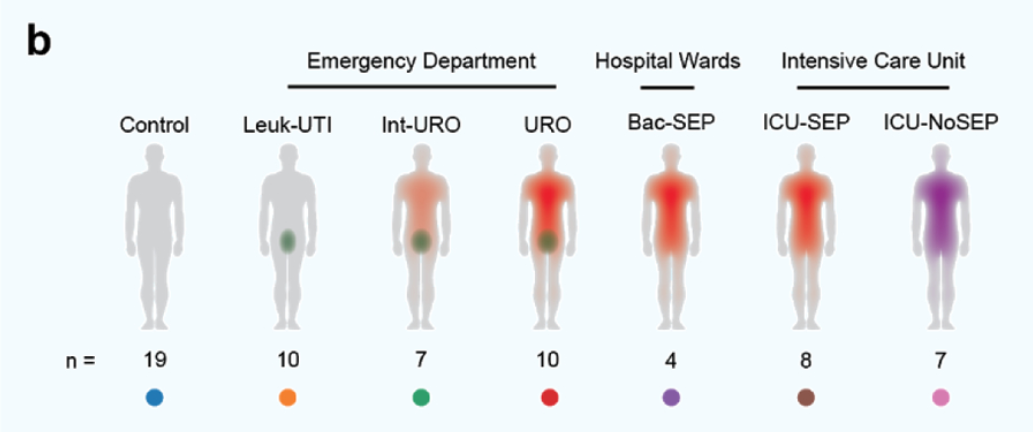

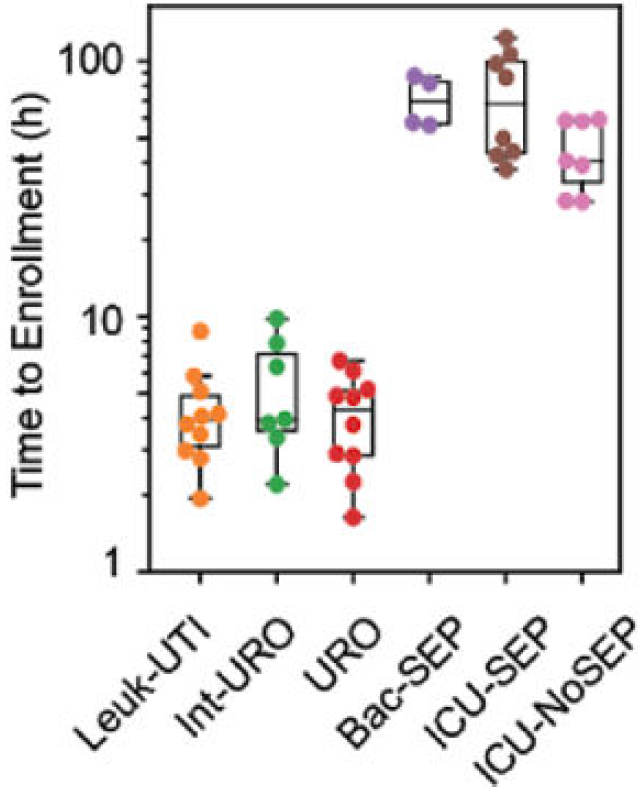

In [82]:
le.fit_transform(['T', 'Mono', 'NK', 'B', 'DC'])

array([4, 2, 3, 0, 1])

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'Cell_Type' as categorical


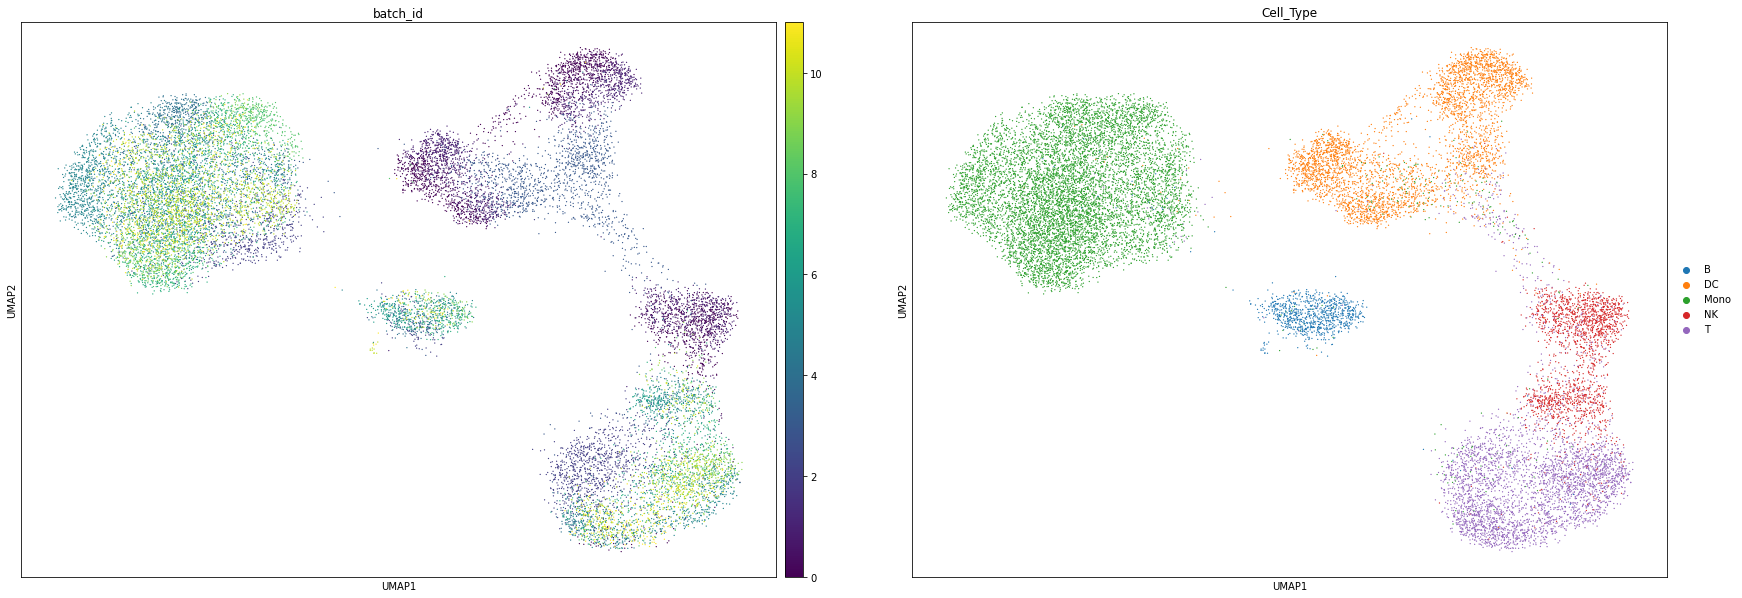

In [97]:
import scanpy as sc
from matplotlib import rcParams

counts_norms = []
annos = []
batch_ids = []
for batch in range(12):
    counts_norms.append(sc_datasets_raw[batch].counts_norm)
    annos.append(sc_datasets_raw[batch].anno)
    batch_ids.append(sc_datasets_raw[batch].batch_id)
adata = ad.AnnData(np.concatenate(counts_norms, axis = 0))
obs = {'Cell_Type': np.concatenate(str_anno),
      'batch_id': np.concatenate(batch_ids)}
obs = pd.DataFrame(obs, index =  np.concatenate(str_anno))
# adata.obs['Cell_Type'] = np.concatenate(annos)
# adata.obs['batch_id'] = np.concatenate(batch_ids)

# obs.set_index(np.concatenate(barcodes))
adata.obs = obs
# obs

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)

# save = 'r./sepsis_results/sepsis_2000'
save = None
rcParams['figure.figsize'] = 14, 10
sc.pl.umap(adata, color = ['batch_id', 'Cell_Type'], save = save)
# sc.pl.umap(adata, color = ['Cell_Type'], save = save)/

# sc.tl.leiden(adata, resolution = 0.1)
# sc.pl.umap(adata, color = ['leiden'], save=save)

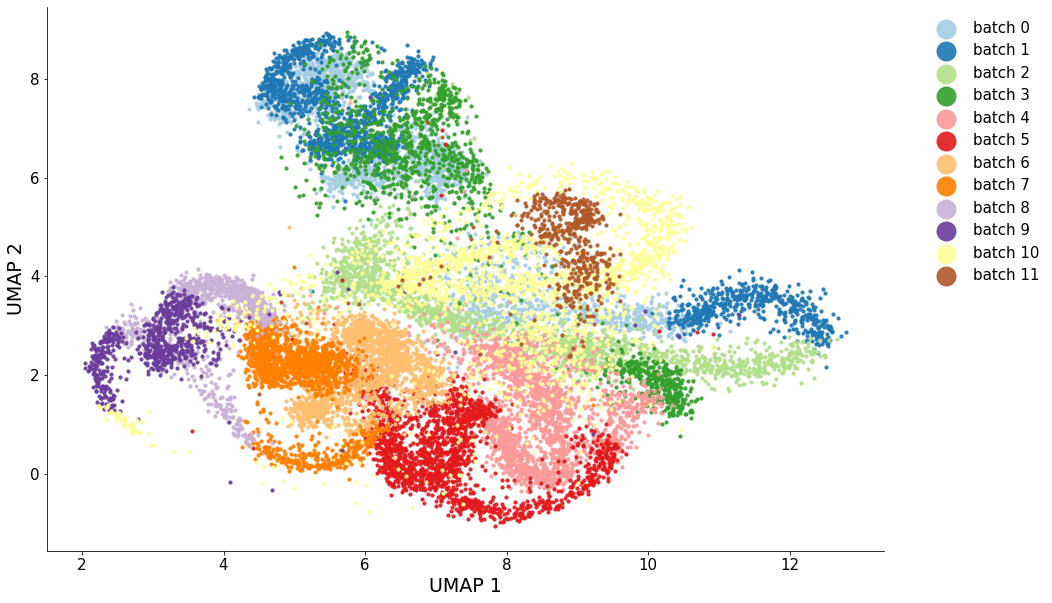

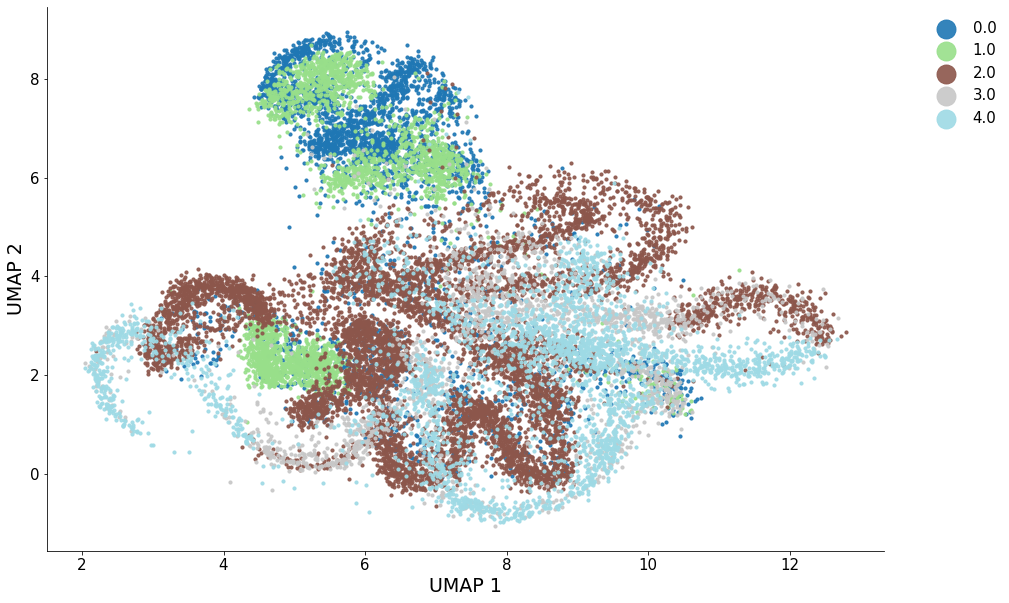

In [99]:
# before integration
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.3, random_state = 0) 
counts_norms = []
annos = []
batch_ids = []
for batch in range(nbatches):
    counts_norms.append(sc_datasets_raw[batch].counts_norm)
    annos.append(sc_datasets_raw[batch].anno)
    batch_ids.append(sc_datasets_raw[batch].batch_id)

x_umap = umap_op.fit_transform(np.concatenate(counts_norms, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + counts_norms[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + counts_norms[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + counts_norms[batch - 1].shape[0]
        end_pointer = start_pointer + counts_norms[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

save_file = None

utils.plot_latent(x_umaps, annos = annos, mode = "modality", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos, mode = "joint", save = save_file, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


In [8]:
import importlib
importlib.reload(train)

<module 'train' from './src/train.py'>

In [9]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        """
        Implementation of the loss described in the paper Supervised Contrastive Learning :
        https://arxiv.org/abs/2004.11362
        :param temperature: int
        """
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, projections, targets):
        """
        :param projections: torch.Tensor, shape [batch_size, projection_dim]
        :param targets: torch.Tensor, shape [batch_size]
        :return: torch.Tensor, scalar
        """
        device = torch.device("cuda") if projections.is_cuda else torch.device("cpu")

        dot_product_tempered = torch.mm(projections, projections.T) / self.temperature
        # Minus max for numerical stability with exponential. Same done in cross entropy. Epsilon added to avoid log(0)
        exp_dot_tempered = (
            torch.exp(dot_product_tempered - torch.max(dot_product_tempered, dim=1, keepdim=True)[0]) + 1e-5
        )

        mask_similar_class = (targets.unsqueeze(1).repeat(1, targets.shape[0]) == targets).to(device)
        mask_anchor_out = (1 - torch.eye(exp_dot_tempered.shape[0])).to(device)
        mask_combined = mask_similar_class * mask_anchor_out
        cardinality_per_samples = torch.sum(mask_combined, dim=1)

        log_prob = -torch.log(exp_dot_tempered / (torch.sum(exp_dot_tempered * mask_anchor_out, dim=1, keepdim=True)))
        supervised_contrastive_loss_per_sample = torch.sum(log_prob * mask_combined, dim=1) / cardinality_per_samples
        supervised_contrastive_loss = torch.mean(supervised_contrastive_loss_per_sample)

        return supervised_contrastive_loss

In [116]:
# New Version
def train_epoch_mmd(model_dict, train_data_loaders, test_data_loaders, optimizer, 
                    n_epoches = 100, interval = 10, use_zinb = True, contr_loss=None, time_dim = 5, group_dim = 5,
                    lamb_mmd = 1e-3, lamb_pi = 1e-5, lamb_recon = 1, lamb_contr_time = 1e-1, lamb_contr_group = 5e-2,):
    loss_zinb_tests = []
    loss_mmd_tests = []
    loss_tests = []
    contr_loss_tests = []
    contr_loss_group = CircleLoss(m=0.25, gamma= 1e-1)
    # contr_loss_group = SupervisedContrastiveLoss()
    contr_feature_time = 'time_point'
    contr_feature_group = 'group_id'
    for epoch in range(n_epoches + 1):
        # train the model
        for data_batch in zip(*train_data_loaders):
            loss_mmd = 0
            loss_zinb = 0
            loss_contr = 0
            loss_contr_group = 0

            zs_mmd = []
            zs_contr = {}
            zs_contr["time"] = []
            zs_contr["group_id"] = []
            labels_contr = {}
            labels_contr["time"] = []
            labels_contr["group_id"] = []
            for idx, x in enumerate(data_batch):
                z = model_dict["encoder"](x["count_stand"].to(device))
                mu, pi, theta = model_dict["decoder"](z)
                # negative log likelihood
                if use_zinb:
                    loss_zinb += ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(device), ridge_lambda = lamb_pi).loss(y_true = x["count"].to(device), y_pred = mu)
                else:
                    # if not use ZINB, then assume the data is Gaussian instead
                    loss_zinb += (mu * x["libsize"].to(device) - x["count"].to(device)).pow(2).sum()

                # NEW
                zs_mmd.append(z[:,(time_dim + group_dim):])
                zs_contr["time"].append(z[:,:time_dim])
                zs_contr["group_id"].append(z[:, time_dim:(time_dim + group_dim)])
                labels_contr["time"].append(x[contr_feature_time])
                labels_contr["group_id"].append(x[contr_feature_group])

            loss_mmd = maximum_mean_discrepancy(xs = zs_mmd, ref_batch = 0)
            # contrastive loss: (latent embeddings, labels)
            loss_contr = contr_loss(torch.cat(zs_contr["time"], dim=0), torch.cat(labels_contr["time"], dim = 0).to(device))
            loss_contr_group = contr_loss(torch.cat(zs_contr["group_id"], dim=0), torch.cat(labels_contr["group_id"], dim = 0).to(device))
            loss = lamb_recon * loss_zinb + lamb_mmd * loss_mmd + loss_contr * lamb_contr_time + loss_contr_group * lamb_contr_group
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # test the model
        if epoch % interval == 0:
            loss_mmd_test = 0
            loss_zinb_test = 0 
            loss_contr_test = 0
            loss_contr_group_test = 0
            for data_batch in zip(*test_data_loaders):
                with torch.no_grad():
                    zs_mmd = []
                    zs_contr = {}
                    zs_contr["time"] = []
                    zs_contr["group_id"] = []
                    labels_contr = {}
                    labels_contr["time"] = []
                    labels_contr["group_id"] = []

                    for idx, x in enumerate(data_batch):
                        z = model_dict["encoder"](x["count_stand"].to(device))
                        mu, pi, theta = model_dict["decoder"](z)
                        if use_zinb:
                            loss_zinb_test += ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(device), ridge_lambda = lamb_pi).loss(y_true = x['count'].to(device), y_pred = mu)
                        else:
                            loss_zinb_test += (mu * x["libsize"].to(device) - x["count"].to(device)).pow(2).sum()

                        # NEW
                        zs_mmd.append(z[:,(time_dim + group_dim):])
                        zs_contr["time"].append(z[:,:time_dim])
                        zs_contr["group_id"].append(z[:, time_dim:(time_dim + group_dim)])
                        labels_contr["time"].append(x[contr_feature_time])
                        labels_contr["group_id"].append(x[contr_feature_group])
                


                    loss_mmd_test = maximum_mean_discrepancy(xs = zs_mmd, ref_batch = 0)
                    # contrastive loss: (latent embeddings, labels)
                    loss_contr_test = contr_loss(torch.cat(zs_contr["time"], dim=0), torch.cat(labels_contr["time"], dim = 0).to(device))
                    loss_contr_group_test = contr_loss_group(torch.cat(zs_contr["group_id"], dim=0), torch.cat(labels_contr["group_id"], dim = 0).to(device))                            
                    loss_test = lamb_recon * loss_zinb_test + lamb_mmd * loss_mmd_test + loss_contr_test * lamb_contr_time + loss_contr_group_test * lamb_contr_group

            info = [
                'mmd loss: {:.3f}'.format(loss_mmd_test.item()),
                'ZINB loss: {:.3f}'.format(loss_zinb_test.item()),
                'contrastive loss: {:.3f}'.format(loss_contr_test.item()),
                'overall loss: {:.3f}'.format(loss_test.item()),
            ]

            print("epoch: ", epoch)
            for i in info:
                print("\t", i)
            contr_loss_tests.append(loss_contr_test.item())
            loss_mmd_tests.append(loss_mmd_test.item())
            loss_zinb_tests.append(loss_zinb_test.item())
            loss_tests.append(loss_test.item())
    return loss_tests, loss_mmd_tests, loss_zinb_tests, contr_loss_tests

In [130]:
# initialize the model
ldim = 32
lr = 5e-4
model_dict = {}
model_dict["encoder"] = model.Encoder(features = [ngenes, 256, 32, ldim], dropout_rate = 0, negative_slope = 0.2).to(device)
model_dict["decoder"] = model.Decoder(features = [ldim, 32, 256, ngenes], dropout_rate = 0, negative_slope = 0.2).to(device)
# initialize the optimizer
param_to_optimize = [
    {'params': model_dict["encoder"].parameters()},
    {'params': model_dict["decoder"].parameters()}
]

optim_ae = torch.optim.Adam(param_to_optimize, lr=lr)

# use Circle loss to distinguish different time points
contrastive_loss = CircleLoss(m=0.3, gamma= 1e-2)
# contrastive_loss = TripletLoss(margin=0.3)
# contrastive_loss = torch.nn.CrossEntropyLoss()
# contrastive_loss = SupervisedContrastiveLoss()
contr_factor = 1e-2
contr_loss_group_factor = 1e-2
lamb_recon = 1
lamb_mmd = 5e-2
n_epoches = 30
time_dim = 15
group_dim = 5

# New Version
losses = train_epoch_mmd(model_dict, train_data_loaders = train_loaders_raw, test_data_loaders = test_loaders_raw, 
                      optimizer = optim_ae, n_epoches = n_epoches, interval = 10, lamb_mmd = lamb_mmd, 
                      lamb_pi = 1e-5, lamb_recon = lamb_recon, use_zinb = True, lamb_contr_time=contr_factor,contr_loss=contrastive_loss, 
                        time_dim = time_dim, group_dim = group_dim, lamb_contr_group = contr_loss_group_factor)

epoch:  0
	 mmd loss: 0.113
	 ZINB loss: 8.245
	 contrastive loss: 36.448
	 overall loss: 8.981
epoch:  10
	 mmd loss: 0.147
	 ZINB loss: 2.949
	 contrastive loss: 36.498
	 overall loss: 3.911
epoch:  20
	 mmd loss: 0.142
	 ZINB loss: 2.580
	 contrastive loss: 36.489
	 overall loss: 4.029
epoch:  30
	 mmd loss: 0.123
	 ZINB loss: 2.511
	 contrastive loss: 36.482
	 overall loss: 3.460


## Metrics for Benchmarking
**I've implemented: 
        NMI, 
        ARI, 
        graph_connectivity,
to help tune model, mostly referring to CLEAR model and paper "Benchmarking atlas-level data integration in single-cell genomics"** - Xinye


In [131]:
# zs = []
# for data_batch in zip(*test_loaders):
#     with torch.no_grad():
#         for idx, x in enumerate(data_batch):
#             z = model_dict["encoder"](x["count_stand"].to(device))
#             mu, pi, theta = model_dict["decoder"](z)
#             zs.append(z.cpu().detach().numpy())

# obs = pd.DataFrame()
# data = ad.AnnData(np.concatenate(zs))
# data.obs['label'] = pd.Series([str(i) for i in np.concatenate(annos)], dtype="category").values
# data.obs['batch'] = pd.Series([str(i) for i in np.concatenate(batch_ids)], dtype="category").values

# # ari and nmi
# ari_nmi(data, annos, resolution=0.08, show_fig=True)
# print('Computing kBET')
# print('kBET score:', kBET(data, 'batch', 'label', embed=None))
# # print("/nGraph Connectivity Score:", graph_connectivity(data, 'label'))

## Loss plot
The change of loss function with iterations

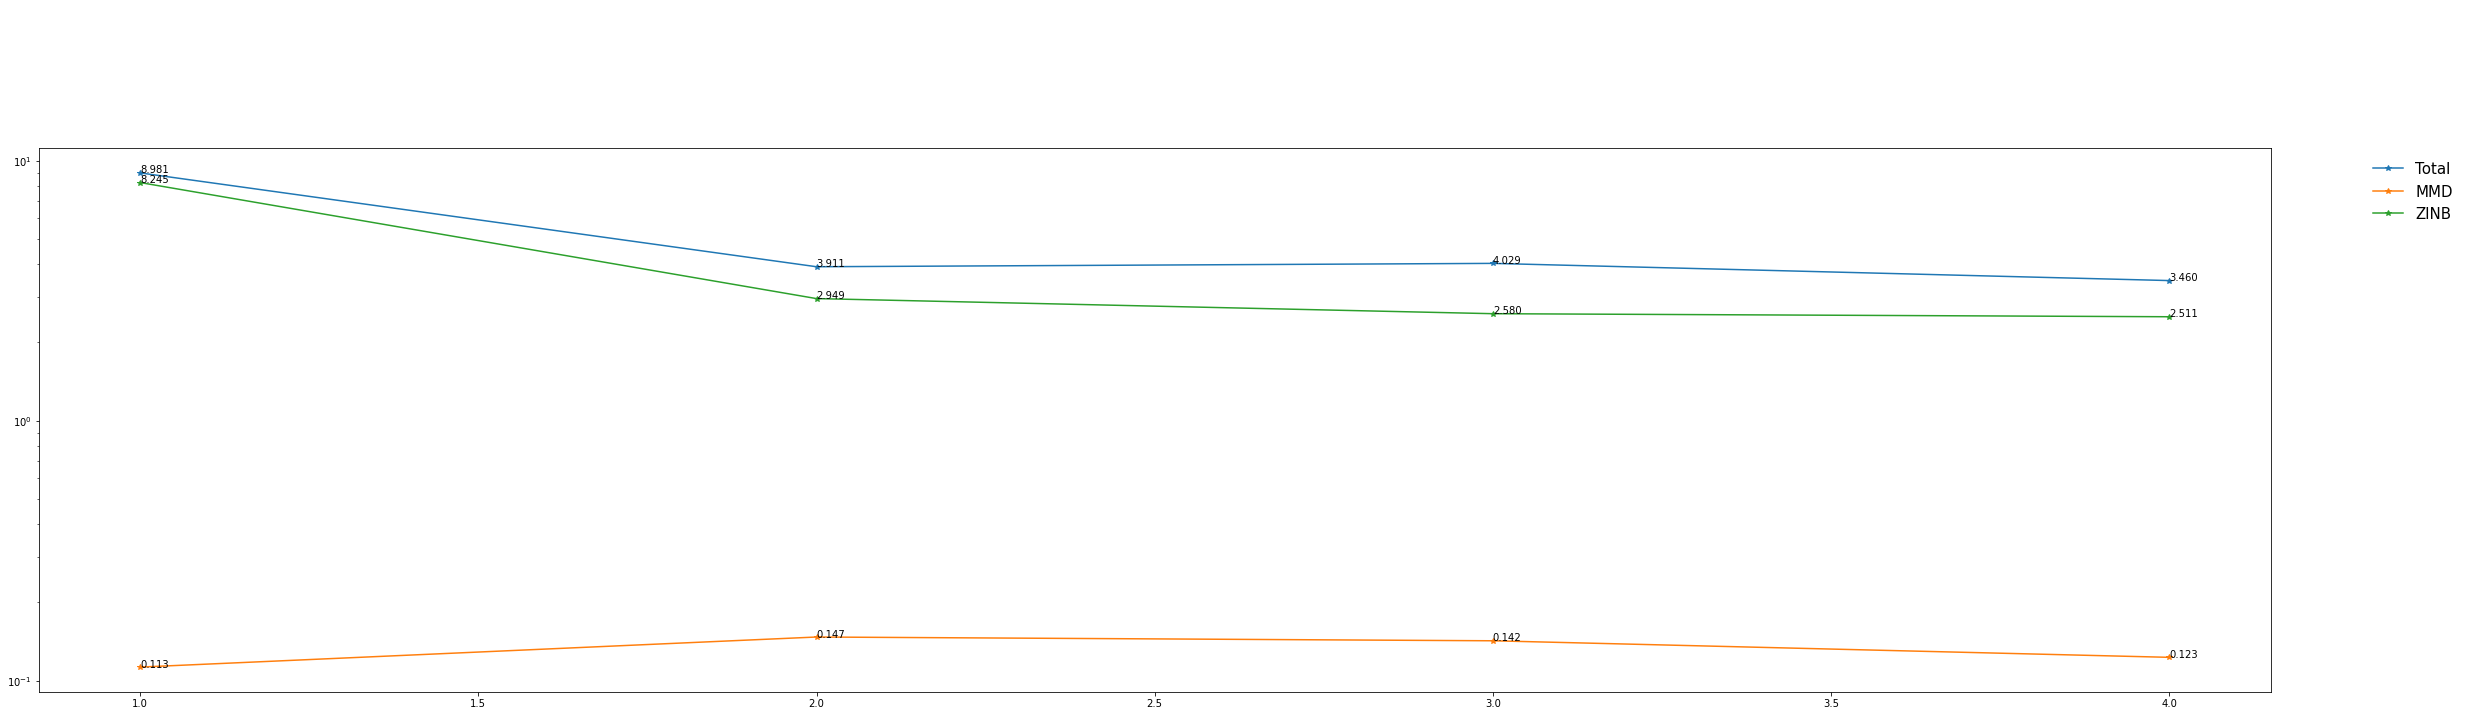

In [132]:

loss_total = losses[0]
loss_mmd = losses[1]
loss_zinb = losses[2]
loss_triplet = losses[3]

iterations = np.arange(1, len(loss_mmd) + 1)
fig = plt.figure(figsize = (40, 10))
ax = fig.add_subplot()
ax.plot(iterations, loss_total, "-*", label = "Total")
ax.plot(iterations, loss_mmd, "-*", label = "MMD")
ax.plot(iterations, loss_zinb, "-*",label = "ZINB")
# ax.plot(iterations, loss_triplet.cpu(), "-*",label = "TRIPLET")
ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
ax.set_yscale("log")
for i,j in zip(iterations,loss_zinb):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_mmd):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_total):
    ax.annotate("{:.3f}".format(j),xy=(i,j))
for i,j in zip(iterations,loss_triplet):
    ax.annotate("{:.3f}".format(j),xy=(i,j)) 

In [133]:
path = '/net/csefiles/xzhanglab/xzhao429/Projects/AntennaVAE/sepsis_results/sepsis_2000/processing_batch/full/'
batch_ids = [0, 1, 6]
save_permit = False
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.3, random_state = 0) 

# Only Visualize group dim

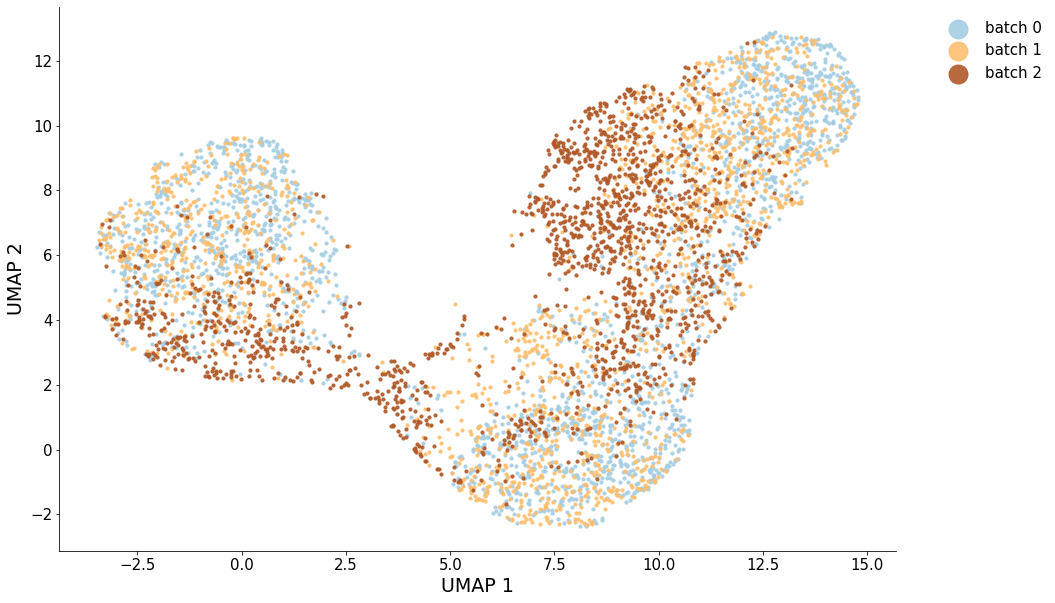

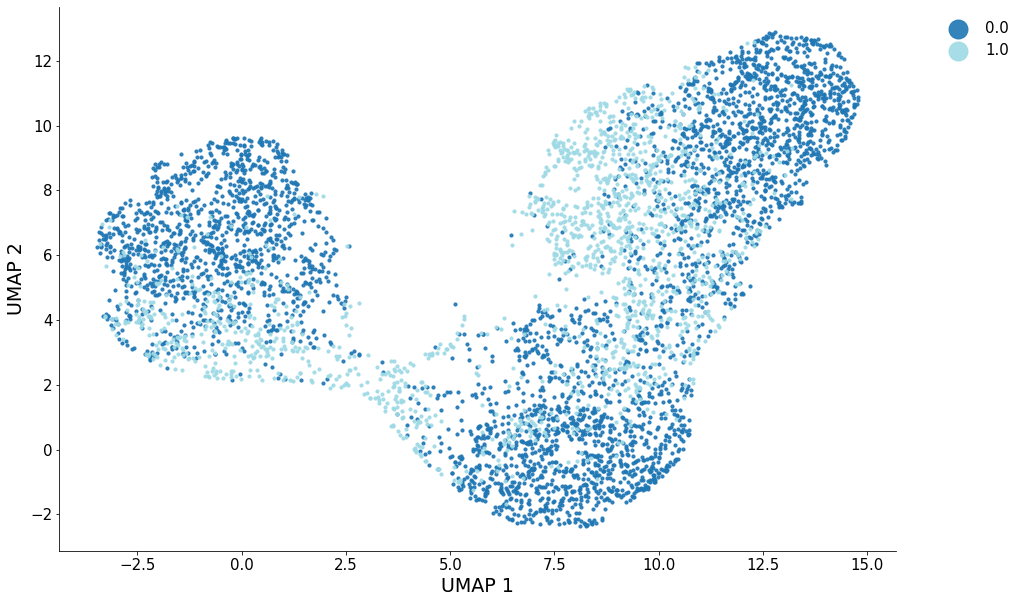

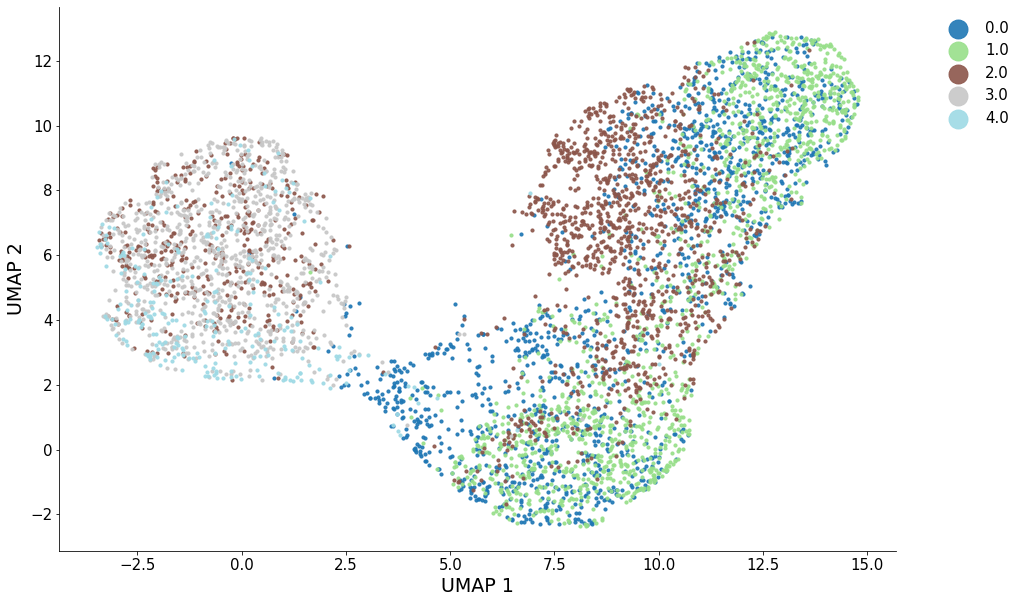

In [134]:
zs = []
# batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []
time_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            time_sub.append(x['time_point'])
            annos_sub.append(x['anno'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0)[:, time_dim:time_dim + group_dim])
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'ONLY_UTI'
save_file_batch = path + 'batch_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file_type = path + 'type_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file_time = path + 'time_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file = None
if not save_permit:
    save_file_batch = save_file
    save_file_type = save_file
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps_no_time, annos = time_sub, mode = "joint", save = save_file_time, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file_type, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


# Only Visualize Time Dims

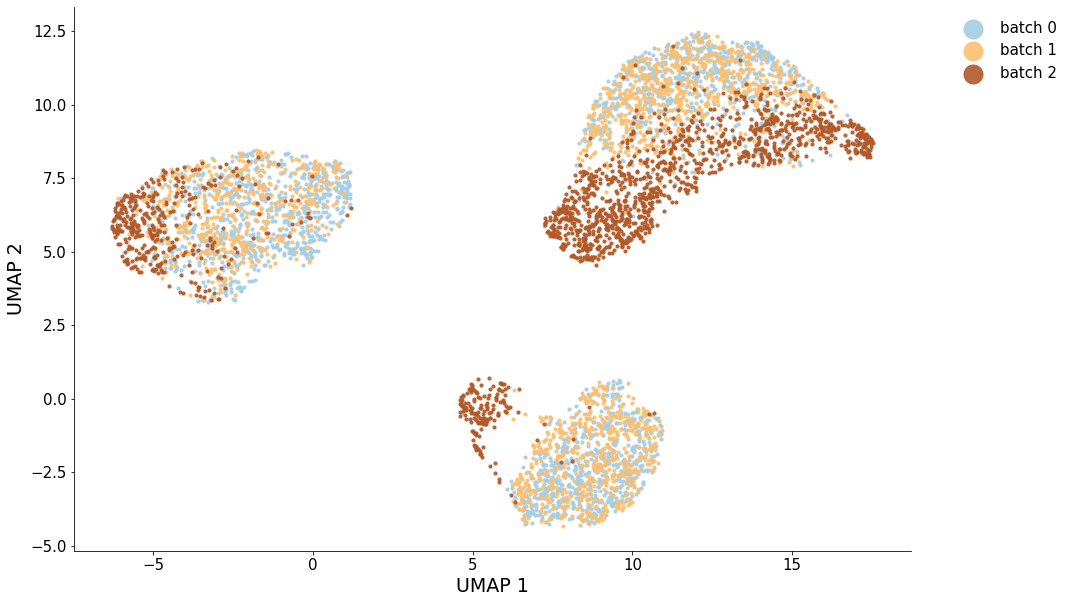

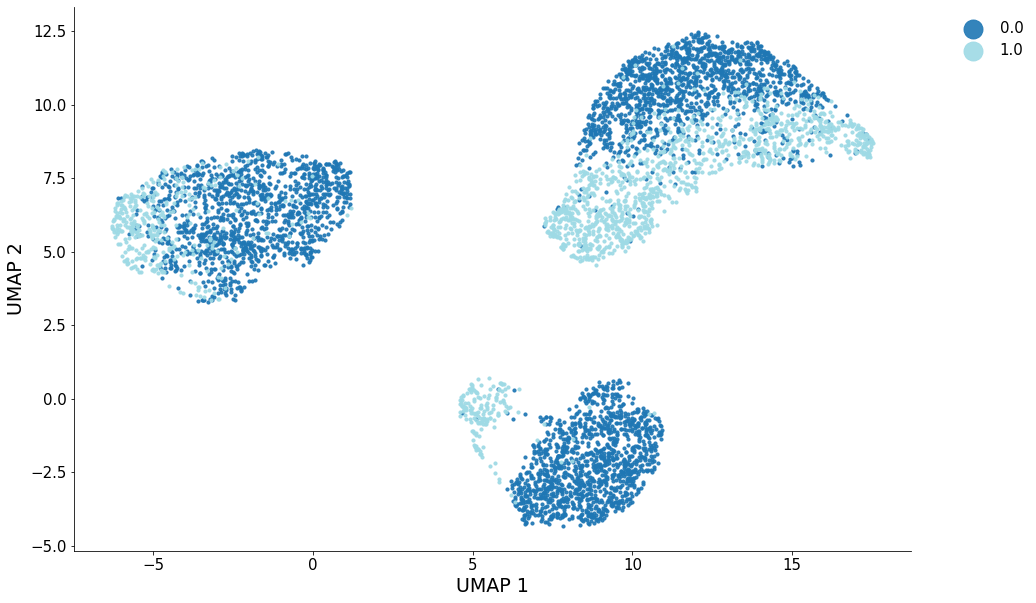

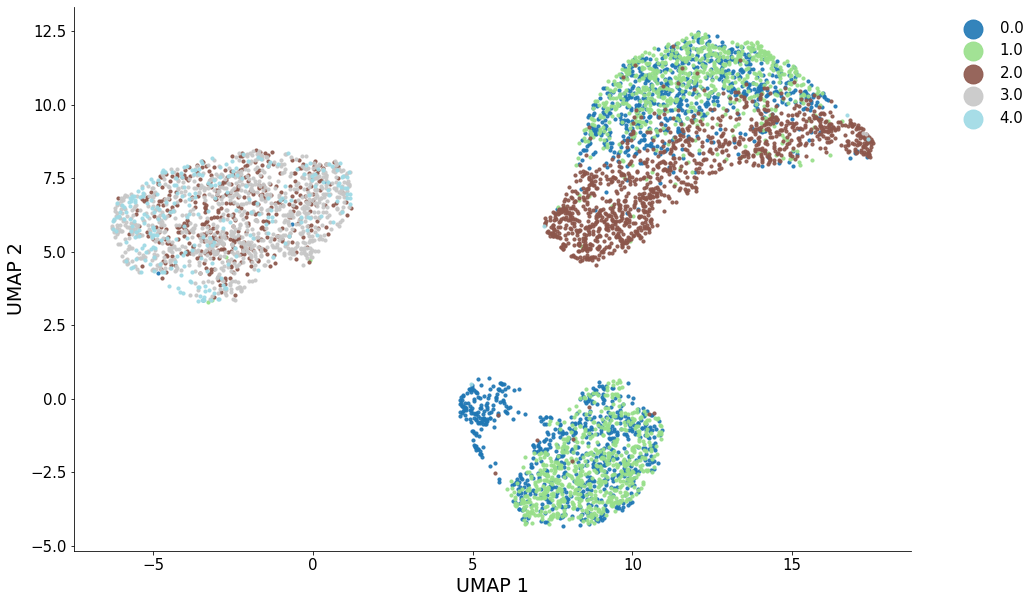

In [135]:
zs = []
# batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []
time_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            time_sub.append(x['time_point'])
            annos_sub.append(x['anno'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0)[:, :time_dim])
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'ONLY_TIME'
save_file_batch = path + 'batch_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file_type = path + 'type_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file_time = path + 'time_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file = None
if not save_permit:
    save_file_batch = save_file
    save_file_type = save_file
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps_no_time, annos = time_sub, mode = "joint", save = save_file_time, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file_type, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualize embedding without UTI dimentions

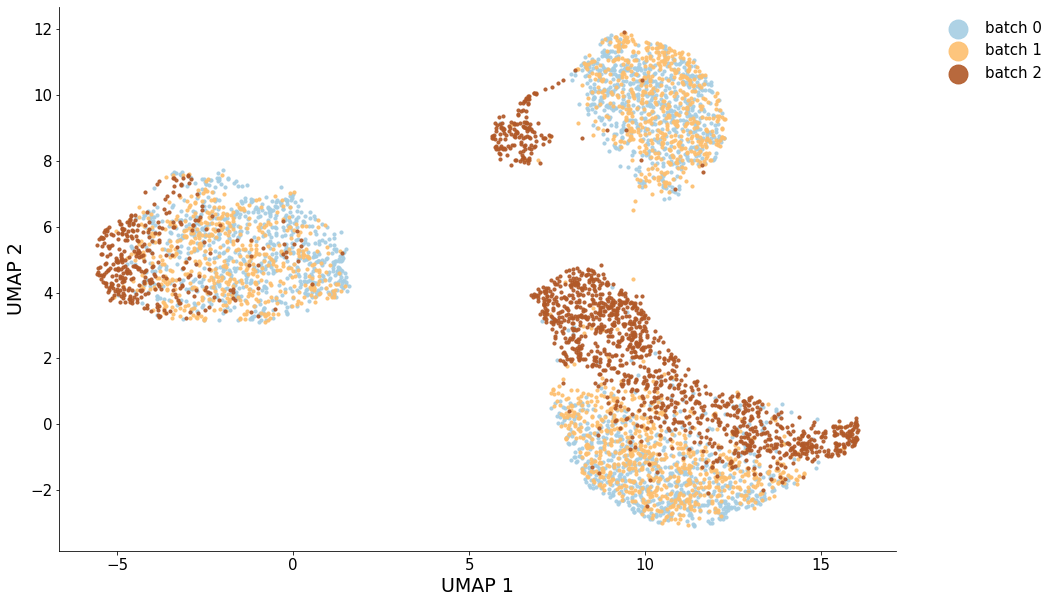

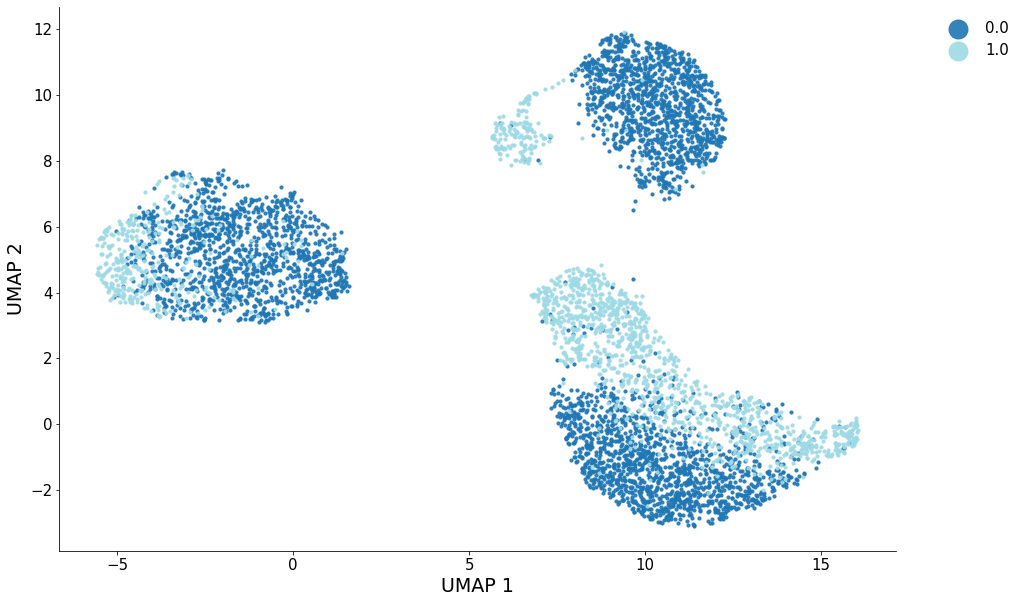

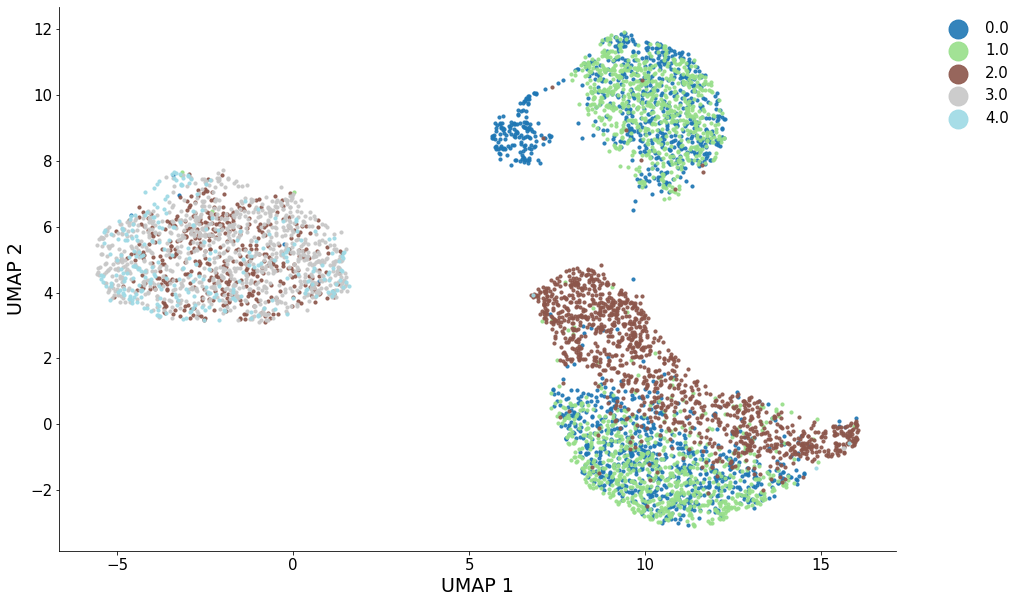

In [136]:
zs = []
# batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []
time_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            time_sub.append(x['time_point'])
            annos_sub.append(x['anno'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate((np.concatenate(zs, axis = 0)[:, : time_dim], np.concatenate(zs, axis = 0)[:, time_dim + group_dim:]), axis=1))
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'NO_UTI'
save_file_batch = path + 'batch_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file_type = path + 'type_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file_time = path + 'time_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file = None
if not save_permit:
    save_file_batch = save_file
    save_file_type = save_file
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps_no_time, annos = time_sub, mode = "joint", save = save_file_time, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file_type, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualize embedding without time dimentions

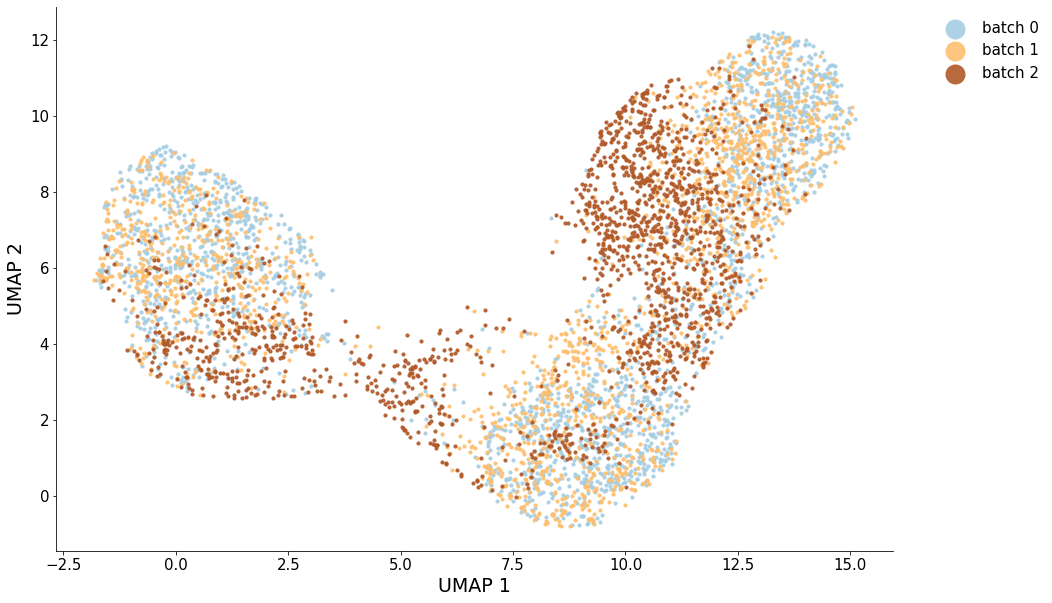

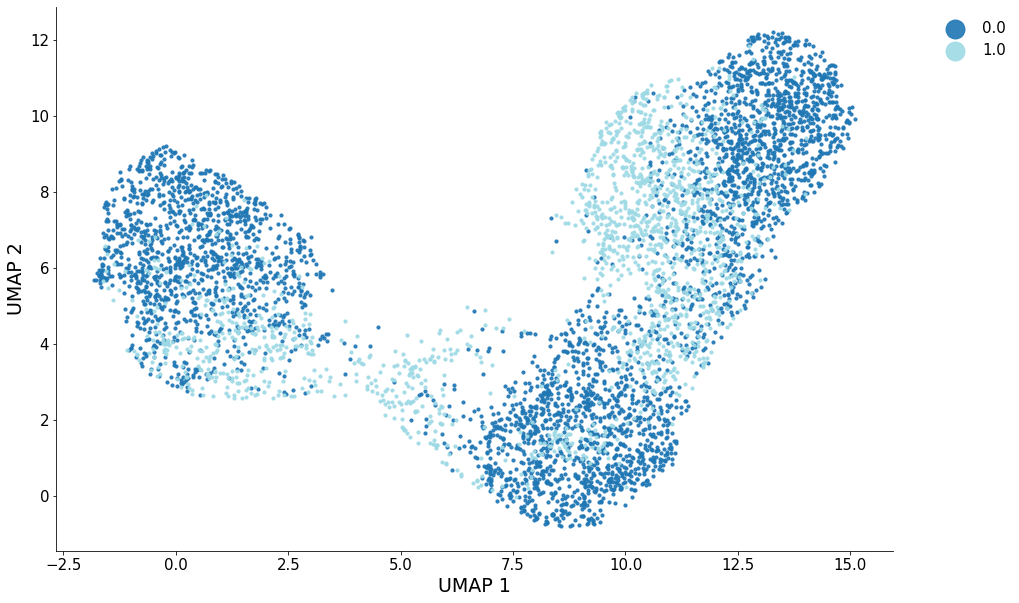

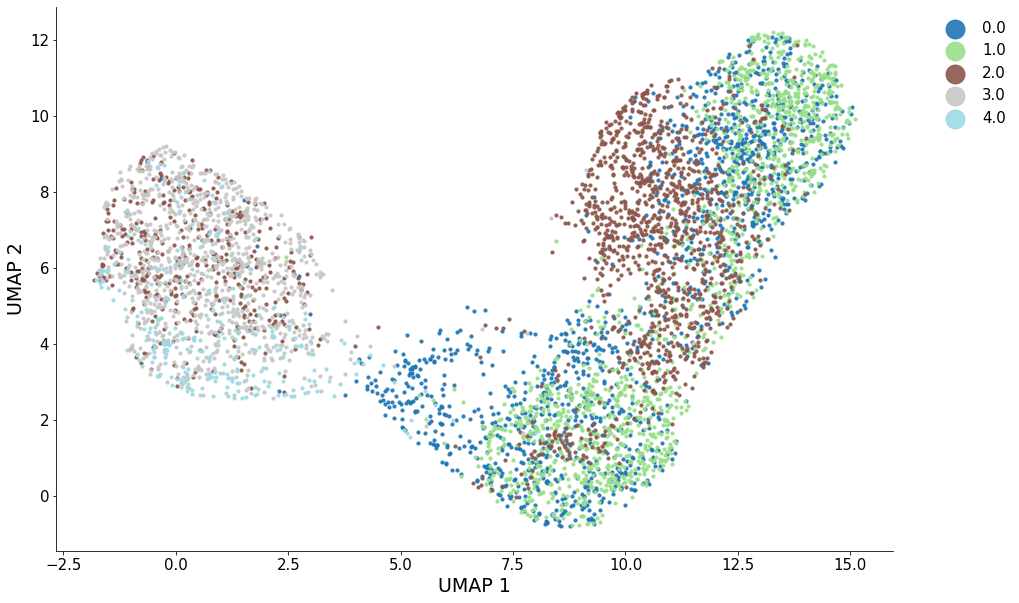

In [137]:
zs = []
# batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []
time_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            time_sub.append(x['time_point'])
            annos_sub.append(x['anno'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0)[:, time_dim:])
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'NO_TIME'
save_file_batch = path + 'batch_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file_type = path + 'type_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file_time = path + 'time_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file = None
if not save_permit:
    save_file_batch = save_file
    save_file_type = save_file
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps_no_time, annos = time_sub, mode = "joint", save = save_file_time, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file_type, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualize embedding without time and UTI dimentions

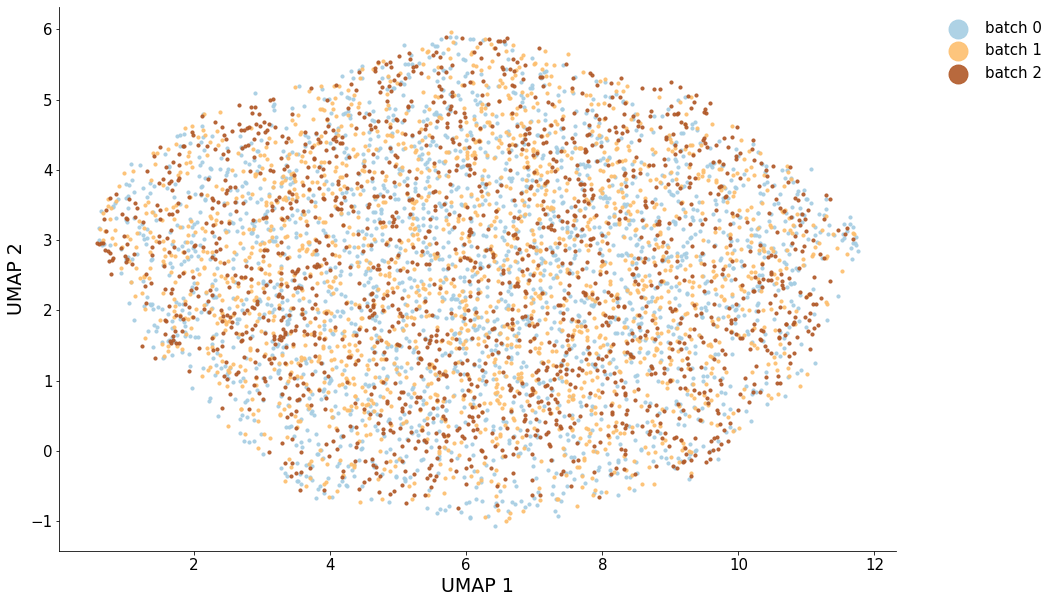

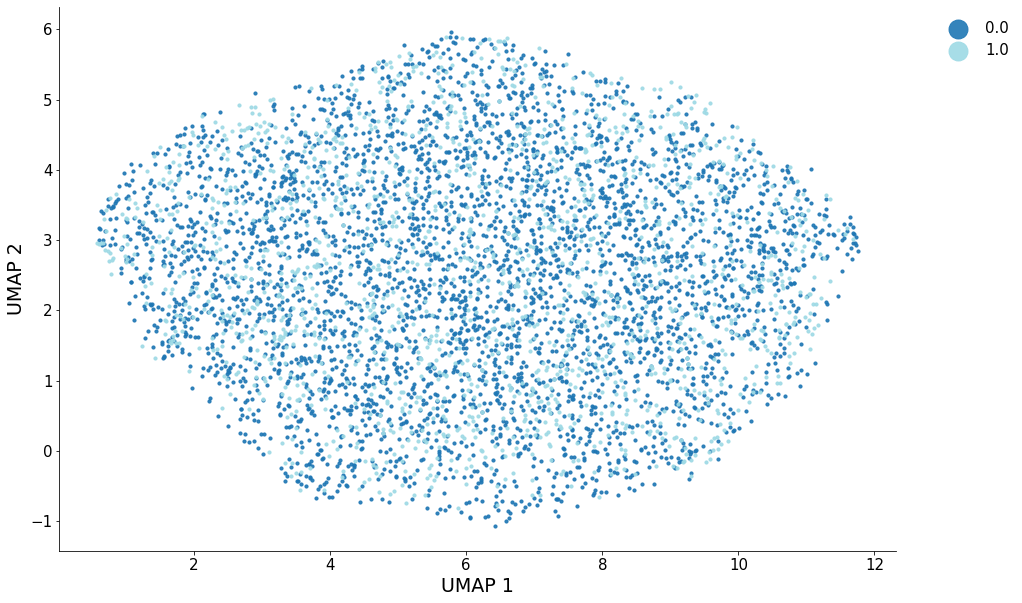

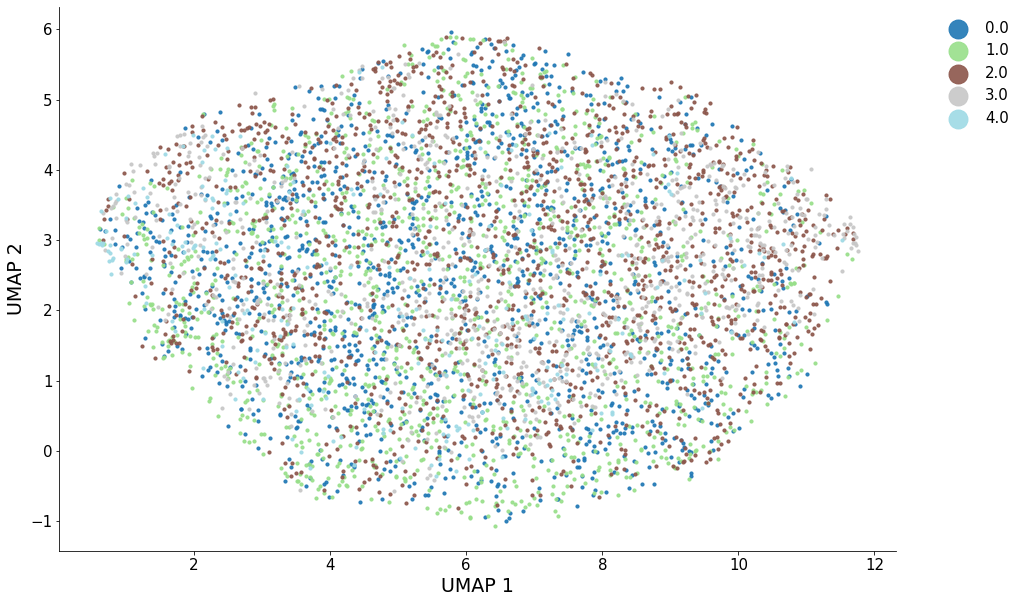

In [138]:
zs = []
# batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []
time_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            time_sub.append(x['time_point'])
            annos_sub.append(x['anno'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0)[:, time_dim + group_dim:])
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'NO_TIME_NO_UTI'
save_file_batch = path + 'batch_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file_type = path + 'type_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file_time = path + 'time_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file = None
if not save_permit:
    save_file_batch = save_file
    save_file_type = save_file
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps_no_time, annos = time_sub, mode = "joint", save = save_file_time, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file_type, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualization of All dim
* **Top**: cells are colored by batch ID
* **Bottom**: cells are colored by ground truth cell type


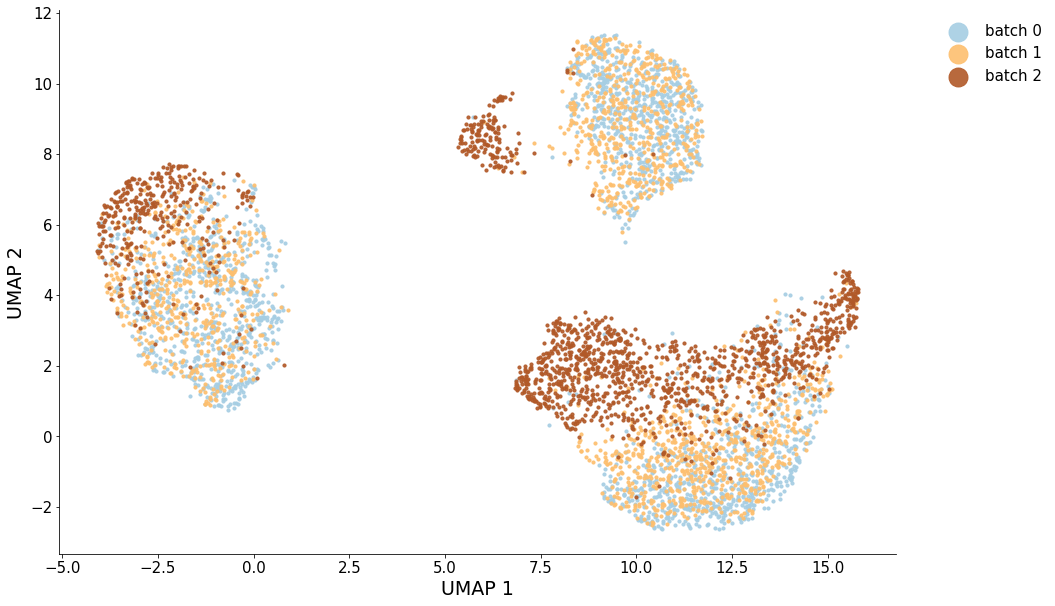

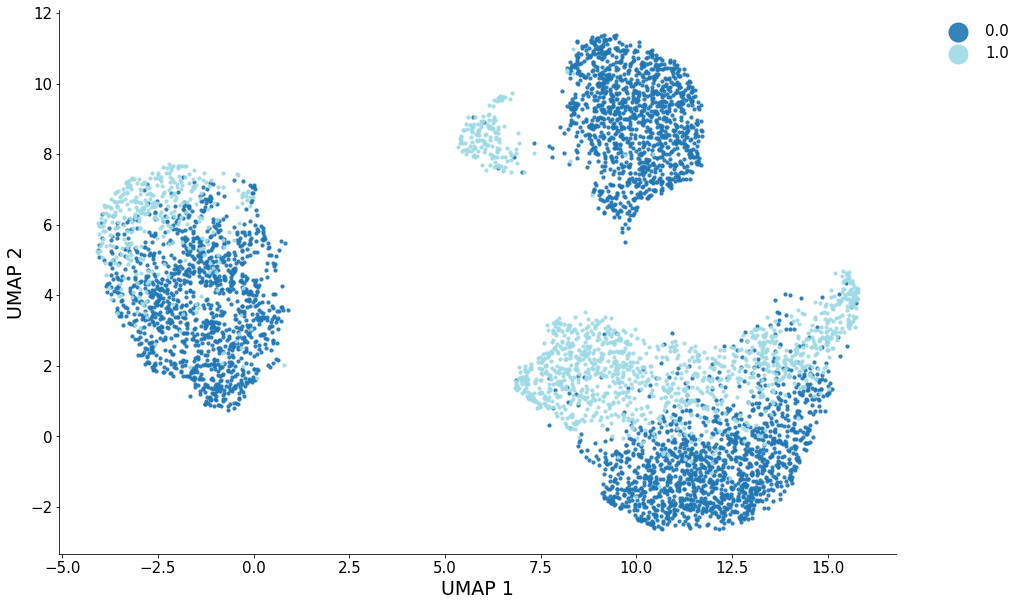

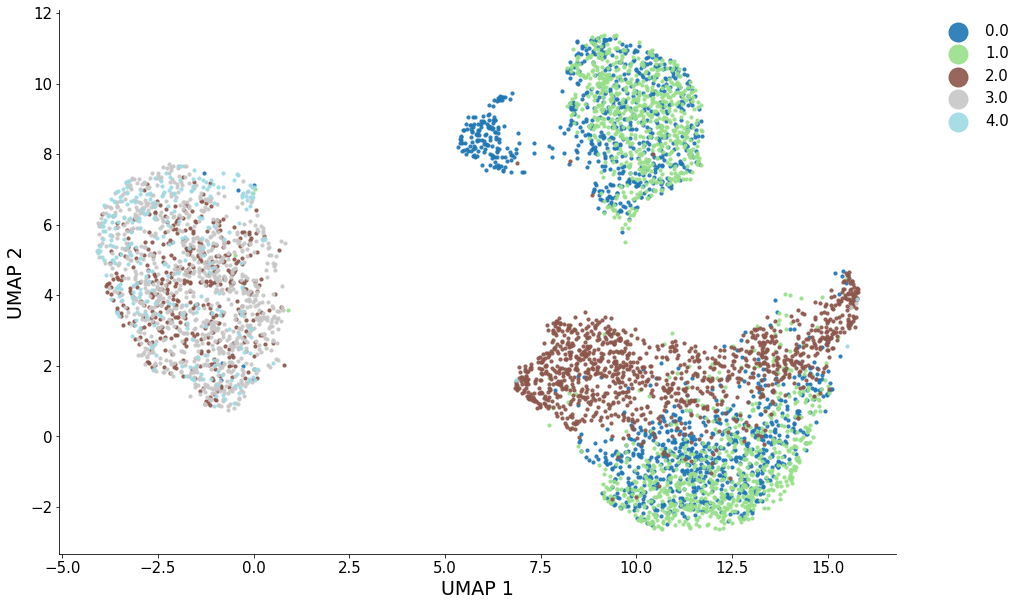

In [139]:
zs = []
# batch_ids = [0, 6]
test_loaders_sub = [test_loaders_raw[i] for i in batch_ids]
nbatches_sub = len(test_loaders_sub)
annos_sub = []
time_sub = []

for data_batch in zip(*test_loaders_sub):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            time_sub.append(x['time_point'])
            annos_sub.append(x['anno'])
            zs.append(z.cpu().detach().numpy())

x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps_no_time = []

for batch in range(nbatches_sub):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps_no_time.append(x_umap[start_pointer:end_pointer,:])
# comment = 'NO_TIME_DIMS_15_TRIPLET_m_0.25_gamma_1e-2'
comment = 'WITH_TIME_UTI'
save_file_batch = path + 'batch_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file_type = path + 'type_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file_time = path + 'time_contr_{}_batch_{}_epoch_{}.png'.format(comment, batch_ids, n_epoches)
save_file = None
if not save_permit:
    save_file_batch = save_file
    save_file_type = save_file
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps_no_time, annos = time_sub, mode = "joint", save = save_file_time, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
utils.plot_latent(x_umaps_no_time, annos = annos_sub, mode = "joint", save = save_file_type, figsize = (15,10), axis_label = "UMAP", markerscale = 6)
# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")


## Visualization of all 8 batches
* **Top**: cells are colored by batch ID
* **Bottom**: cells are colored by ground truth cell type


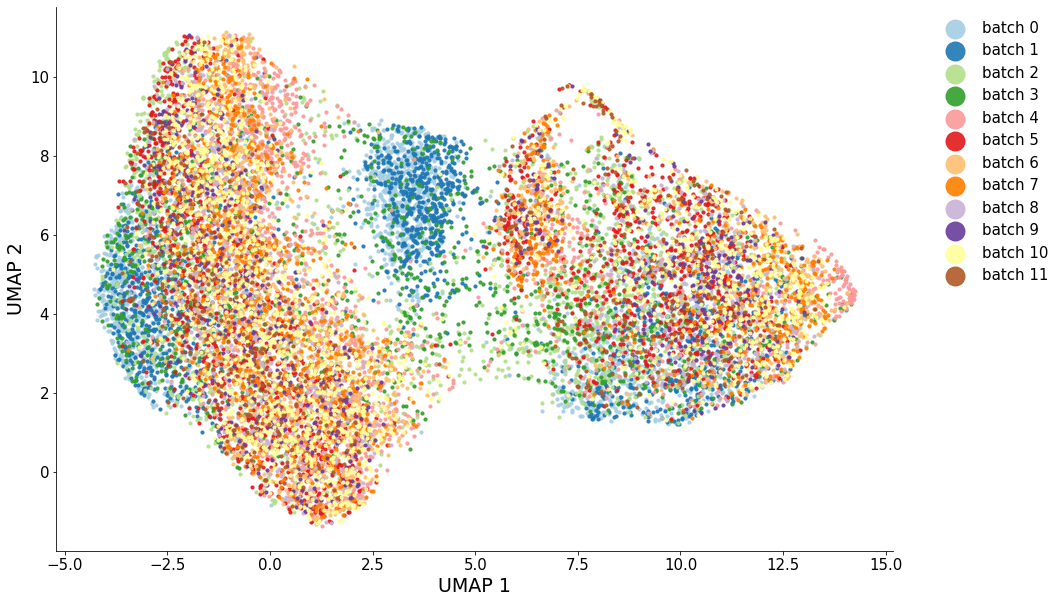

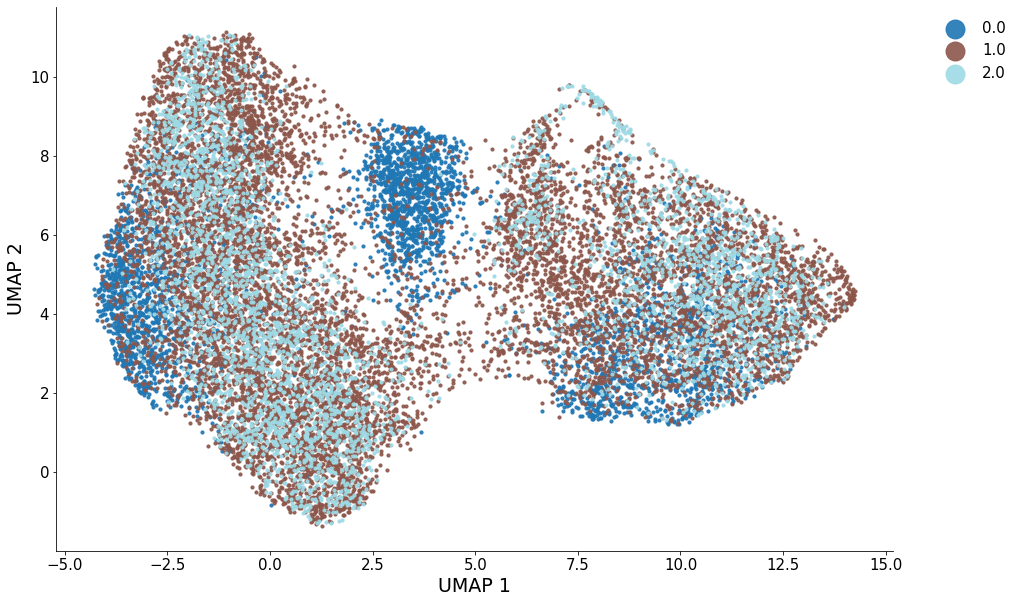

In [140]:
zs = []
annos_sub = []

for data_batch in zip(*test_loaders_raw):
    with torch.no_grad():
        for idx, x in enumerate(data_batch):
            z = model_dict["encoder"](x["count_stand"].to(device))
            mu, pi, theta = model_dict["decoder"](z)
            annos_sub.append(x['time_point'])
            zs.append(z.cpu().detach().numpy())
            
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(nbatches):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == (nbatches - 1):
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
comment = 'ALL_WIEH_TIME'
save_file_batch = path + 'batch_contr_{}_epoch_{}.png'.format(comment, n_epoches)
save_file_type = path + 'type_contr_{}_epoch_{}.png'.format(comment, n_epoches)
save_file = None
if not save_permit:
    save_file_batch = save_file
    save_file_type = save_file
utils.plot_latent(x_umaps, annos = annos_sub, mode = "modality", save = save_file_batch, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

utils.plot_latent(x_umaps, annos = annos_sub, mode = "joint", save = save_file_type, figsize = (15,10), axis_label = "UMAP", markerscale = 6)

# utils.plot_latent(x_umaps, annos = annos, mode = "separate", save = None, figsize = (10,70), axis_label = "Latent")
